In [13]:
import torch
import numpy as np
from typing import Dict, Any, List

%run toy-models.ipynb

# Set device
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Step 0: loss=0.184440, lr=0.001000
Step 5: loss=0.175414, lr=0.001000
Step 10: loss=0.159055, lr=0.001000
Step 15: loss=0.098884, lr=0.001000
Step 20: loss=0.115598, lr=0.001000
Step 25: loss=0.049928, lr=0.001000
Step 30: loss=0.164430, lr=0.001000
Step 35: loss=0.051154, lr=0.001000
Step 40: loss=0.122808, lr=0.001000
Step 45: loss=0.064673, lr=0.001000
Step 49: loss=0.030120, lr=0.001000
Step 0: avg_loss=0.045750, lr=0.001000
Step 99: avg_loss=0.031376, lr=0.001000


# Classifying Expert Weights (Ortho, Superposition, etc)
Implementation for n=2 and n=3 (each a separate function).

In [35]:
def classify_expert_weights_2d(expert_weights: torch.Tensor, tolerance: float = 0.1):
    """Classify expert weight matrices for 2-feature models."""
    n_experts, n_features, n_hidden = expert_weights.shape
    classifications = {}
    
    for expert_id in range(n_experts):
        weights = expert_weights[expert_id]  # Shape: [n_features, n_hidden]
        
        # For each hidden dimension, classify the feature weights
        hidden_classifications = []
        for hidden_dim in range(n_hidden):
            # Handle the case where n_hidden=1 (tensor gets squeezed)
            if n_hidden == 1:
                feature_weights = weights.squeeze()  # Shape: [n_features]
            else:
                feature_weights = weights[:, hidden_dim]  # Shape: [n_features]
            
            weights_norm = feature_weights / torch.norm(feature_weights)
            weights_np = weights_norm.cpu().detach().numpy()
            
            # Check for superposition patterns (2 features)
            superposition_patterns = [
                np.array([1.0, 1.0]),   # Both features positive
                np.array([1.0, -1.0]),  # Features opposite
                np.array([-1.0, 1.0]),  # Features opposite (reversed)
                np.array([-1.0, -1.0])  # Both features negative
            ]
            
            # Single features (orthogonal)
            single_patterns = [
                np.array([1.0, 0.0]),  # Feature 0 only
                np.array([0.0, 1.0])   # Feature 1 only
            ]
            
            # Test all patterns
            max_similarity = 0
            best_pattern = None
            best_pattern_type = None
            
            # Test superposition patterns
            for pattern in superposition_patterns:
                pattern_norm = pattern / np.linalg.norm(pattern)
                similarity = np.abs(np.dot(weights_np, pattern_norm))
                if similarity > max_similarity:
                    max_similarity = similarity
                    best_pattern = pattern
                    best_pattern_type = 'superposition'
            
            # Test single patterns
            for pattern in single_patterns:
                pattern_norm = pattern / np.linalg.norm(pattern)
                similarity = np.abs(np.dot(weights_np, pattern_norm))
                if similarity > max_similarity:
                    max_similarity = similarity
                    best_pattern = pattern
                    best_pattern_type = 'single'
            
            # Determine classification
            if max_similarity > (1.0 - tolerance):
                if best_pattern_type == 'superposition':
                    # Identify which features are superimposed
                    active_features = np.where(np.abs(best_pattern) > 0.1)[0]
                    signs = best_pattern[active_features]
                    if np.all(signs > 0):
                        classification = f'superposition_both_positive'
                    elif np.all(signs < 0):
                        classification = f'superposition_both_negative'
                    else:
                        classification = f'superposition_opposite'
                elif best_pattern_type == 'single':
                    # Identify which single feature
                    active_feature = np.where(np.abs(best_pattern) > 0.1)[0][0]
                    classification = f'orthogonal_feature_{active_feature}'
            else:
                classification = 'incomprehensible'
            
            hidden_classifications.append({
                'classification': classification,
                'similarity': max_similarity,
                'weights': feature_weights.tolist(),
                'pattern': best_pattern.tolist() if best_pattern is not None else None
            })
        
        classifications[f'expert_{expert_id}'] = {
            'hidden_dimensions': hidden_classifications,
            'raw_weights': weights.tolist()
        }
    
    return classifications

# Sample expert weights with 2 features, 1 hidden dim
expert_weights_2d = torch.tensor([[[ 0.2857],
                                   [ 0.3748]],
                                  [[-0.9991],
                                   [ 0.4402]]])

# Classify and print results
classifications = classify_expert_weights_2d(expert_weights_2d)
print("\nExpert Weight Classifications (2D):")
for expert_id, result in classifications.items():
    print(f"\n{expert_id}:")
    for i, hidden_result in enumerate(result['hidden_dimensions']):
        print(f"  Hidden dim {i}: {hidden_result['classification']} (similarity: {hidden_result['similarity']:.3f})")
        print(f"    Weights: {hidden_result['weights']}")
        if hidden_result['pattern']:
            print(f"    Pattern: {hidden_result['pattern']}")


Expert Weight Classifications (2D):

expert_0:
  Hidden dim 0: superposition_both_positive (similarity: 0.991)
    Weights: [0.2856999933719635, 0.3747999966144562]
    Pattern: [1.0, 1.0]

expert_1:
  Hidden dim 0: superposition_opposite (similarity: 0.932)
    Weights: [-0.9991000294685364, 0.44020000100135803]
    Pattern: [1.0, -1.0]


In [33]:
# Classify expert weights into different types (superposition, orthogonal, incomprehensible)
# This is a simple classification based on the weights of the expert.

# Classify expert weights
def classify_expert_weights_n3(expert_weights: torch.Tensor, tolerance: float = 0.1):
    """Classify expert weight matrices into different types."""
    n_experts, n_features, n_hidden = expert_weights.shape
    classifications = {}
    
    for expert_id in range(n_experts):
        weights = expert_weights[expert_id].squeeze()  # Shape: [n_features, n_hidden]
        
        # For each hidden dimension, classify the feature weights
        hidden_classifications = []
        for hidden_dim in range(n_hidden):
            feature_weights = weights[:, hidden_dim]  # Shape: [n_features]
            weights_norm = feature_weights / torch.norm(feature_weights)
            weights_np = weights_norm.cpu().detach().numpy()
            
            # Check for superposition patterns
            # All three features superimposed
            all_three_patterns = [
                np.array([1.0, 1.0, 1.0]),
                np.array([1.0, 1.0, -1.0]),
                np.array([1.0, -1.0, 1.0]),
                np.array([-1.0, 1.0, 1.0]),
                np.array([1.0, -1.0, -1.0]),
                np.array([-1.0, 1.0, -1.0]),
                np.array([-1.0, -1.0, 1.0]),
                np.array([-1.0, -1.0, -1.0])
            ]
            
            # Pairs of features superimposed
            pair_patterns = [
                np.array([1.0, 1.0, 0.0]),  # Features 0,1 superimposed
                np.array([1.0, 0.0, 1.0]),  # Features 0,2 superimposed
                np.array([0.0, 1.0, 1.0]),  # Features 1,2 superimposed
                np.array([1.0, -1.0, 0.0]), # Features 0,1 superimposed (opposite)
                np.array([1.0, 0.0, -1.0]), # Features 0,2 superimposed (opposite)
                np.array([0.0, 1.0, -1.0]), # Features 1,2 superimposed (opposite)
                np.array([-1.0, 1.0, 0.0]), # Features 0,1 superimposed (opposite)
                np.array([-1.0, 0.0, 1.0]), # Features 0,2 superimposed (opposite)
                np.array([0.0, -1.0, 1.0])  # Features 1,2 superimposed (opposite)
            ]
            
            # Single features (orthogonal)
            single_patterns = [
                np.array([1.0, 0.0, 0.0]),  # Feature 0 only
                np.array([0.0, 1.0, 0.0]),  # Feature 1 only
                np.array([0.0, 0.0, 1.0])   # Feature 2 only
            ]
            
            # Test all patterns
            max_similarity = 0
            best_pattern = None
            best_pattern_type = None
            
            # Test all-three patterns
            for pattern in all_three_patterns:
                pattern_norm = pattern / np.linalg.norm(pattern)
                similarity = np.abs(np.dot(weights_np, pattern_norm))
                if similarity > max_similarity:
                    max_similarity = similarity
                    best_pattern = pattern
                    best_pattern_type = 'all_three'
            
            # Test pair patterns
            for pattern in pair_patterns:
                pattern_norm = pattern / np.linalg.norm(pattern)
                similarity = np.abs(np.dot(weights_np, pattern_norm))
                if similarity > max_similarity:
                    max_similarity = similarity
                    best_pattern = pattern
                    best_pattern_type = 'pair'
            
            # Test single patterns
            for pattern in single_patterns:
                pattern_norm = pattern / np.linalg.norm(pattern)
                similarity = np.abs(np.dot(weights_np, pattern_norm))
                if similarity > max_similarity:
                    max_similarity = similarity
                    best_pattern = pattern
                    best_pattern_type = 'single'
            
            # Determine classification
            if max_similarity > (1.0 - tolerance):
                if best_pattern_type == 'all_three':
                    # Identify which features are superimposed
                    active_features = np.where(np.abs(best_pattern) > 0.1)[0]
                    signs = best_pattern[active_features]
                    if np.all(signs > 0):
                        classification = f'superposition_all_three_positive'
                    elif np.all(signs < 0):
                        classification = f'superposition_all_three_negative'
                    else:
                        classification = f'superposition_all_three_mixed'
                elif best_pattern_type == 'pair':
                    # Identify which pair is superimposed
                    active_features = np.where(np.abs(best_pattern) > 0.1)[0]
                    signs = best_pattern[active_features]
                    feature_names = [f'feature_{i}' for i in active_features]
                    if np.all(signs > 0):
                        classification = f'superposition_pair_{"_".join(feature_names)}_positive'
                    elif np.all(signs < 0):
                        classification = f'superposition_pair_{"_".join(feature_names)}_negative'
                    else:
                        classification = f'superposition_pair_{"_".join(feature_names)}_mixed'
                elif best_pattern_type == 'single':
                    # Identify which single feature
                    active_feature = np.where(np.abs(best_pattern) > 0.1)[0][0]
                    classification = f'orthogonal_feature_{active_feature}'
            else:
                classification = 'incomprehensible'
            
            hidden_classifications.append({
                'classification': classification,
                'similarity': max_similarity,
                'weights': feature_weights.tolist(),
                'pattern': best_pattern.tolist() if best_pattern is not None else None
            })
        
        classifications[f'expert_{expert_id}'] = {
            'hidden_dimensions': hidden_classifications,
            'raw_weights': weights.tolist()
        }
    
    return classifications

# Sample expert weights with 3 features, 2 hidden dims (equiv. to model.W_experts)
expert_weights_3d = torch.tensor([
    # Expert 0
    [[ 0.7071,  0.0000],  # Feature 0: [hidden_dim_0, hidden_dim_1]
        [ 0.7071,  0.0000],  # Feature 1: [hidden_dim_0, hidden_dim_1] 
        [ 0.0000,  1.0000]], # Feature 2: [hidden_dim_0, hidden_dim_1]
    
    # Expert 1
    [[ -0.5774,  0.5774],  # Feature 0: [hidden_dim_0, hidden_dim_1]
        [ -0.5774,  -0.5774],  # Feature 1: [hidden_dim_0, hidden_dim_1]
        [ 0.5774, -0.5774]]  # Feature 2: [hidden_dim_0, hidden_dim_1]
])
    
# Classify and print results
classifications = classify_expert_weights_n3(expert_weights_3d)
print("\nExpert Weight Classifications:")
for expert_id, result in classifications.items():
    print(f"\n{expert_id}:")
    for i, hidden_result in enumerate(result['hidden_dimensions']):
        print(f"  Hidden dim {i}: {hidden_result['classification']} (similarity: {hidden_result['similarity']:.3f})")
        print(f"    Weights: {hidden_result['weights']}")
        if hidden_result['pattern']:
            print(f"    Pattern: {hidden_result['pattern']}")


Expert Weight Classifications:

expert_0:
  Hidden dim 0: superposition_pair_feature_0_feature_1_positive (similarity: 1.000)
    Weights: [0.707099974155426, 0.707099974155426, 0.0]
    Pattern: [1.0, 1.0, 0.0]
  Hidden dim 1: orthogonal_feature_2 (similarity: 1.000)
    Weights: [0.0, 0.0, 1.0]
    Pattern: [0.0, 0.0, 1.0]

expert_1:
  Hidden dim 0: superposition_all_three_mixed (similarity: 1.000)
    Weights: [-0.5774000287055969, -0.5774000287055969, 0.5774000287055969]
    Pattern: [1.0, 1.0, -1.0]
  Hidden dim 1: superposition_all_three_mixed (similarity: 1.000)
    Weights: [0.5774000287055969, -0.5774000287055969, -0.5774000287055969]
    Pattern: [-1.0, 1.0, 1.0]


# Compute Router Probabilities

Given weight matrix, likelihood expert is activated via sampling. 

In [27]:
def compute_router_probabilities(gate_matrix, feature_probability=None, n_samples=10000):
    """
    Compute probability that router picks first expert.
    
    Args:
        gate_matrix: Shape [n_experts, n_features] - the gate weights
        feature_probability: Probability of feature being active (None for uniform)
        n_samples: Number of samples to estimate probability
    
    Returns:
        prob_with_data: Probability considering data sparsity
        prob_without_data: Probability assuming uniform data
    """
    device = gate_matrix.device
    n_experts, n_features = gate_matrix.shape
    
    # 1. Probability WITHOUT considering data properties (uniform data)
    # Generate uniform random features
    uniform_features = torch.rand(n_samples, n_features, device=device)
    
    # Compute gate scores and probabilities
    gate_scores_uniform = torch.einsum("bf,ef->be", uniform_features, gate_matrix)
    gate_probs_uniform = F.softmax(gate_scores_uniform, dim=-1)
    
    # Probability of selecting first expert
    prob_without_data = gate_probs_uniform[:, 0].mean().item()
    
    # 2. Probability WITH considering data properties (sparse data)
    if feature_probability is not None:
        # Generate sparse data according to feature_probability
        sparse_features = torch.where(
            torch.rand(n_samples, n_features, device=device) <= feature_probability,
            torch.rand(n_samples, n_features, device=device),
            torch.zeros(n_samples, n_features, device=device)
        )
        
        # Compute gate scores and probabilities for sparse data
        gate_scores_sparse = torch.einsum("bf,ef->be", sparse_features, gate_matrix)
        gate_probs_sparse = F.softmax(gate_scores_sparse, dim=-1)
        
        # Probability of selecting first expert
        prob_with_data = gate_probs_sparse[:, 0].mean().item()
    else:
        prob_with_data = prob_without_data
    
    return prob_with_data, prob_without_data

# Example usage:
print("Gate matrix:")
print(model.gate)

print(f"\nFeature probability: {model.feature_probability.item()}")

# Compute probabilities
prob_with_data, prob_without_data = compute_router_probabilities(
    model.gate, 
    feature_probability=model.feature_probability,
    n_samples=10000
)

print(f"\nRouter probabilities for first expert:")
print(f"With data sparsity: {prob_with_data:.3f}")
print(f"Without data sparsity (uniform): {prob_without_data:.3f}")

# For multiple experts, you can also compute for each expert:
def compute_all_expert_probabilities(gate_matrix, feature_probability=None, n_samples=10000):
    """
    Compute probability for each expert being selected.
    """
    device = gate_matrix.device
    n_experts, n_features = gate_matrix.shape
    
    # Uniform data
    uniform_features = torch.rand(n_samples, n_features, device=device)
    gate_scores_uniform = torch.einsum("bf,ef->be", uniform_features, gate_matrix)
    gate_probs_uniform = F.softmax(gate_scores_uniform, dim=-1)
    probs_without_data = gate_probs_uniform.mean(dim=0).cpu().detach().numpy()
    
    # Sparse data
    if feature_probability is not None:
        sparse_features = torch.where(
            torch.rand(n_samples, n_features, device=device) <= feature_probability,
            torch.rand(n_samples, n_features, device=device),
            torch.zeros(n_samples, n_features, device=device)
        )
        gate_scores_sparse = torch.einsum("bf,ef->be", sparse_features, gate_matrix)
        gate_probs_sparse = F.softmax(gate_scores_sparse, dim=-1)
        probs_with_data = gate_probs_sparse.mean(dim=0).cpu().detach().numpy()
    else:
        probs_with_data = probs_without_data
    
    return probs_with_data, probs_without_data

# Compute for all experts
probs_with_data, probs_without_data = compute_all_expert_probabilities(
    model.gate, 
    feature_probability=model.feature_probability
)

print(f"\nRouter probabilities for all experts:")
for i in range(len(probs_with_data)):
    print(f"Expert {i}: with_data={probs_with_data[i]:.3f}, without_data={probs_without_data[i]:.3f}")

Gate matrix:
Parameter containing:
tensor([[-18.1975, -18.1975, -18.1630, -18.1363, -18.1721],
        [  2.1948,   2.1893,   2.1897,   2.1929,   2.2022],
        [  2.1949,   2.1897,   2.1881,   2.1939,   2.1986]],
       requires_grad=True)

Feature probability: 0.10000000149011612

Router probabilities for first expert:
With data sparsity: 0.203
Without data sparsity (uniform): 0.000

Router probabilities for all experts:
Expert 0: with_data=0.208, without_data=0.000
Expert 1: with_data=0.396, without_data=0.500
Expert 2: with_data=0.396, without_data=0.500


# Tracker Expert Allocation over Time

Currently only supports for k=1.

Step 0: loss=3.196511, lr=0.001000

Step 50 - Router evolution:
  Expert 2: 20.70%
  Expert 3: 24.50%
  Expert 0: 11.80%
  Expert 4: 15.60%
  Expert 1: 27.40%
Step 50: loss=3.024709, lr=0.001000

Step 100 - Router evolution:
  Expert 1: 15.30%
  Expert 3: 27.20%
  Expert 2: 21.60%
  Expert 4: 17.50%
  Expert 0: 18.40%
Step 100: loss=2.937372, lr=0.001000

Step 150 - Router evolution:
  Expert 1: 16.40%
  Expert 0: 21.80%
  Expert 4: 18.00%
  Expert 2: 21.30%
  Expert 3: 22.50%
Step 150: loss=2.809900, lr=0.001000

Step 200 - Router evolution:
  Expert 2: 14.00%
  Expert 1: 28.50%
  Expert 0: 14.90%
  Expert 4: 23.70%
  Expert 3: 18.90%
Step 200: loss=2.876830, lr=0.001000

Step 250 - Router evolution:
  Expert 3: 22.60%
  Expert 1: 18.00%
  Expert 0: 16.40%
  Expert 4: 19.20%
  Expert 2: 23.80%
Step 250: loss=2.761827, lr=0.001000

Step 300 - Router evolution:
  Expert 3: 17.60%
  Expert 4: 22.80%
  Expert 1: 14.70%
  Expert 2: 21.10%
  Expert 0: 23.80%
Step 300: loss=2.714963, lr=0.00

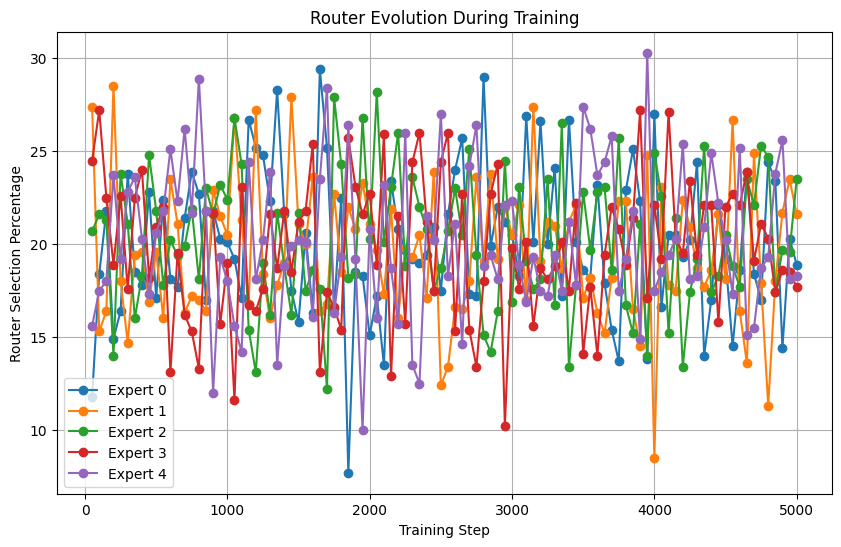

In [26]:
# Tools to track gate expert selection statistics
# Currently only works for k=1

import torch
import numpy as np

class RouterSelectionHook:
    def __init__(self):
        self.expert_selections = {}  # {expert_id: count}
        self.total_selections = 0
        self.batch_size = 0
        
    def __call__(self, hook_data):
        """Hook function called during training."""
        model = hook_data['model']
        batch = hook_data.get('batch', None)
        
        if batch is None:
            # Generate a batch to analyze router behavior
            batch = model.generate_batch(1000)
        
        # Get router probabilities for this batch
        with torch.no_grad():
            expert_weights, top_k_indices, _ = model.compute_active_experts(batch)
            
            # For k=1, track which expert was selected for each input
            if model.config.n_active_experts == 1:
                selected_experts = top_k_indices.squeeze(-1)  # [batch_size]
                
                # Count selections for each expert
                for expert_id in selected_experts.cpu().numpy():
                    if expert_id not in self.expert_selections:
                        self.expert_selections[expert_id] = 0
                    self.expert_selections[expert_id] += 1
                
                self.total_selections += len(selected_experts)
                self.batch_size = len(selected_experts)
    
    def get_statistics(self):
        """Get router selection statistics."""
        if self.total_selections == 0:
            return {}
        
        stats = {
            'total_selections': self.total_selections,
            'expert_counts': dict(self.expert_selections),
            'expert_percentages': {}
        }
        
        for expert_id, count in self.expert_selections.items():
            stats['expert_percentages'][expert_id] = (count / self.total_selections) * 100
        
        return stats
    
    def print_statistics(self):
        """Print current router selection statistics."""
        stats = self.get_statistics()
        
        if not stats:
            print("No router selections recorded yet.")
            return
        
        print(f"\n=== Router Selection Statistics ===")
        print(f"Total selections: {stats['total_selections']}")
        print(f"Batch size: {self.batch_size}")
        print(f"Expert counts: {stats['expert_counts']}")
        print(f"Expert percentages:")
        for expert_id, percentage in stats['expert_percentages'].items():
            print(f"  Expert {expert_id}: {percentage:.2f}%")
        
        # Check for load balancing
        n_experts = len(stats['expert_counts'])
        if n_experts > 0:
            expected_percentage = 100.0 / n_experts
            print(f"Expected percentage per expert: {expected_percentage:.2f}%")
            
            # Calculate load balancing metric
            percentages = list(stats['expert_percentages'].values())
            variance = np.var(percentages)
            print(f"Load balancing variance: {variance:.2f}")

# Alternative: Hook that tracks router behavior over time
class RouterEvolutionHook:
    def __init__(self, log_interval=100):
        self.log_interval = log_interval
        self.step = 0
        self.router_history = []  # List of (step, expert_percentages) tuples
        
    def __call__(self, hook_data):
        self.step += 1
        
        if self.step % self.log_interval == 0:
            # Create temporary hook to get current statistics
            temp_hook = RouterSelectionHook()
            temp_hook(hook_data)
            
            stats = temp_hook.get_statistics()
            if stats:
                self.router_history.append((self.step, stats['expert_percentages']))
                
                print(f"\nStep {self.step} - Router evolution:")
                for expert_id, percentage in stats['expert_percentages'].items():
                    print(f"  Expert {expert_id}: {percentage:.2f}%")
    
    def plot_evolution(self):
        """Plot router evolution over time."""
        if not self.router_history:
            print("No router history to plot.")
            return
        
        import matplotlib.pyplot as plt
        
        steps = [step for step, _ in self.router_history]
        expert_ids = set()
        for _, percentages in self.router_history:
            expert_ids.update(percentages.keys())
        
        plt.figure(figsize=(10, 6))
        for expert_id in sorted(expert_ids):
            percentages = [data.get(expert_id, 0) for _, data in self.router_history]
            plt.plot(steps, percentages, label=f'Expert {expert_id}', marker='o')
        
        plt.xlabel('Training Step')
        plt.ylabel('Router Selection Percentage')
        plt.title('Router Evolution During Training')
        plt.legend()
        plt.grid(True)
        plt.show()

def create_model():
    """Train model with router selection tracking."""
    config = Config(
        n_features=100,
        n_hidden=5,
        n_experts=5,
        n_active_experts=1,
        load_balancing_loss=True,
    )
    
    model = MoEModel(
        config=config,
        device=DEVICE,
        # Create a range of values around 1 for importance, length = n_features
        importance = torch.tensor([0.8 + 0.4 * i / (config.n_features - 1) if config.n_features > 1 else 1.0 for i in range(config.n_features)]),
        feature_probability=torch.tensor(0.1)
    )

    return model

# Example usage:
if __name__ == "__main__":

    # Train with hook
    # router_hook = RouterSelectionHook()
    # optimize(create_model(), n_batch=512, steps=5000, print_freq=100, lr=1e-3, hooks=[router_hook])
    # router_hook.print_statistics()

    # Or train with evolution tracking
    evolution_hook = RouterEvolutionHook(log_interval=50)
    optimize(create_model(), n_batch=512, steps=5000, print_freq=50, lr=1e-3, hooks=[evolution_hook])
    evolution_hook.plot_evolution()